In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)

# Aurora result analysis from this experiment

Aurora has TB size slice amplitudes, so cannot load all amplitudes and store in RAM. Must sequentially process them.

### Skip the steps below to load exiting norm bounds Rs from disk.
We cannot actually run this because the full uncoarsened amplitudes are not published for all samples.

In [71]:
# frequencies = np.zeros(1000)
# delta = 5 * 10**-16
# Rs = [0 for _ in range(17)]
# for circuit in tqdm(range(11933)):
#     amplitudes_dir = f'/flare/CertRandomness/minzhaoliu/results/circuit_{circuit}_amplitudes.npy'
#     amplitudes = np.load(amplitudes_dir)
#     frequencies += np.histogram(np.abs(amplitudes.reshape(-1)), bins=np.arange(0, 5*10**-13 + delta, delta))[0]

#     Rs_for_sample = []
#     i = 0
#     while amplitudes.shape[-1] >= 128:
#         Rs[i] = max(Rs[i], np.max(np.abs(amplitudes)))
#         i += 1
#         amplitudes = amplitudes.reshape(-1, 2)
#         amplitudes = np.sum(amplitudes, axis=1)

# np.save('norm_frequencies.npy', frequencies)
# np.save('maximum_slice_norm_for_different_grouping_of_slices.npy', Rs)

100%|██████████| 11933/11933 [1:28:21<00:00,  2.25it/s] 


In [3]:
# for i, R in enumerate(Rs):
#     print(f'{2**(23 - i)} slices has maximum norm {R}.')

# Output looks like
'''
8388608 slices has maximum norm 8.42624039119888e-13.
4194304 slices has maximum norm 9.812073029080715e-13.
2097152 slices has maximum norm 1.3601304327606756e-12.
1048576 slices has maximum norm 1.7175762765178626e-12.
524288 slices has maximum norm 2.021792021994484e-12.
262144 slices has maximum norm 2.630136776773928e-12.
131072 slices has maximum norm 3.416575616171924e-12.
65536 slices has maximum norm 4.483156467588456e-12.
32768 slices has maximum norm 5.906867876770416e-12.
16384 slices has maximum norm 8.513631639950336e-12.
8192 slices has maximum norm 1.1482619542702022e-11.
4096 slices has maximum norm 1.5687106127981743e-11.
2048 slices has maximum norm 2.2311862427071283e-11.
1024 slices has maximum norm 2.945288457567585e-11.
512 slices has maximum norm 4.341077150527006e-11.
256 slices has maximum norm 5.887246939950685e-11.
128 slices has maximum norm 8.334419265842996e-11.
''';

We observe the frequency decays exponentially in the norm. Therefore, we assume twice the maximum norm is safe.

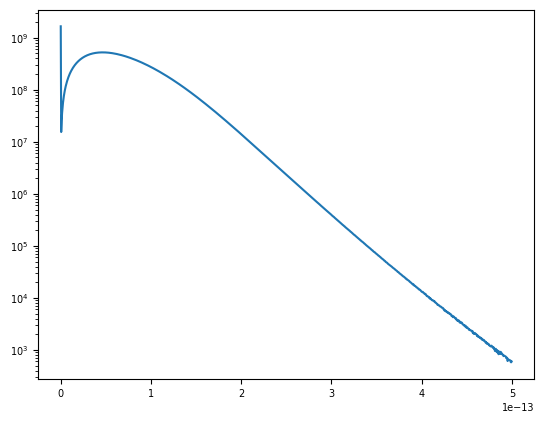

In [78]:
# plt.plot(np.arange(delta/2, 5*10**-13, delta), frequencies)
# plt.yscale('log')

### Start from here

In [4]:
Rs = np.load('maximum_slice_norm_for_different_grouping_of_slices.npy')

In [5]:
def solve_increasing(f, target, low, high):
    while low <= high:
        mid = (high + low) / 2
        if mid == high or mid == low:
            return mid
        ans = f(mid)
        error = ans - target
        if np.abs(error) / target < 0.01:
            return mid
        if error > 0:
            high = mid
        else:
            low = mid

To reproduce Aurora data, download complete amplitudes or chunked (coarsened) amplitudes from our Zenodo release.

In [ ]:
n = 64
m = 11933 # actual number of validated circuits
circuits_to_compute_delta_XEB_for = 10 # Can be increase all the way to m, but will take a long time.

delta_XEBs = [[] for _ in range(17)]
for circuit in tqdm(range(circuits_to_compute_delta_XEB_for)):
    amplitudes_dir = f'amplitudes/complete_circuit_{circuit}_amplitudes.npy'
    amplitudes = np.load(amplitudes_dir)
    compressed_amplitudes = amplitudes.reshape(-1, 512)
    compressed_amplitudes = compressed_amplitudes.sum(axis=1)
    compressed_amplitudes_dir = f'amplitudes/circuit_{circuit}_amplitudes.npy'
    np.save(compressed_amplitudes_dir, compressed_amplitudes)

    these_slices = amplitudes

    i = 0
    
    while these_slices.shape[-1] >= 128:
        R = Rs[i]
        sample_amplitude = np.sum(these_slices)
        sample_direction = sample_amplitude / np.abs(sample_amplitude)
        rotated_slice_amplitudes = these_slices * np.conj(sample_direction)
        r = np.abs(rotated_slice_amplitudes)
        theta = np.angle(rotated_slice_amplitudes)
        delta_probs = 2 * np.abs(sample_amplitude) * (np.real(rotated_slice_amplitudes) + R)
        delta_XEBs[i].append(2**n * delta_probs / m)

        these_slices = these_slices.reshape(-1, 2)
        these_slices = np.sum(these_slices, axis=1)

        i += 1


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


In [28]:
for i in range(17):
    print(np.max(delta_XEBs[i]))

2.019423896225642e-06
2.388805332052371e-06
3.4004738926637766e-06
4.197847727787002e-06
5.055084071574542e-06
6.8352336926701225e-06
9.120857411914206e-06
1.1607200384319832e-05
1.597778101653912e-05
2.3009061193981664e-05
3.0706754066833633e-05
4.20424681062282e-05
5.772246565611396e-05
7.584761226605782e-05
0.00010722840131003449
0.00014446511568711847
0.0002026072214187805


In [29]:
f_target = 0.001

prs = []

for i in tqdm(range(17)):
    sum_delta_xebs = np.sum(delta_XEBs[i])
    def f_function(c):
        # verification_probs = 1 - np.exp(-c*np.array(delta_XEBs[i], dtype=float))
        verification_probs = c * sum_delta_xebs
        total_verification_budget = np.sum(verification_probs) * m / len(delta_XEBs[i])
        f = total_verification_budget / (2**(23 - i) * m)
        return f

    c = solve_increasing(f_function, f_target, 1, 2000)

    pr = np.exp(-c*0.01)
    prs.append(pr)

100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


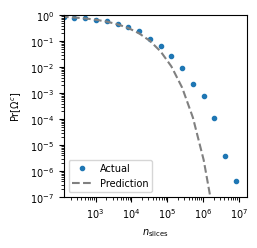

In [36]:
mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
ax1.plot(2**np.arange(23, 6, -1), prs, '.', label='Actual')
ax1.plot(2**np.arange(23, 6, -1), prs[-1]**np.sqrt(2**np.arange(16, -1, -1)), '--', color='gray', label='Prediction')
ax1.set_ylim(10**-7, 1)
ax1.set_xlim(128, 2**24)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$n_{\rm slices}$')
ax1.set_ylabel(r'$\Pr[\Omega^c]$')
plt.legend()
plt.savefig('abort_probability_scaling_aurora.pdf')

# Frontier result analysis from previous experiment

`frontier_slices.npy` and `frontier_aggregated_probs.npy` are from the experiment in M. Liu et. al., Nature 640, 343-348 (2025).

### They are already provided in the repository, but one can verify they are the same as downloading from the previous released dataset.

If you wish to verify, download `frontier_slices.npy` and `aggregated_probs.npy` from https://zenodo.org/records/12952178 Data for "Certified Randomness Using a Trapped-Ion Quantum Computer".

`frontier_slices.npy` can be found at `reproduce_verification/light_verification`.

`aggregated_probs.npy` can be found at `reproduce_verification/data`, which should be renamed `frontier_aggregated_probs.npy`.

In [6]:
all_slices = np.load('frontier_slices.npy')
probs = np.load('frontier_aggregated_probs.npy')
nslices = all_slices.shape[1]

### Distribution of slice magnitudes

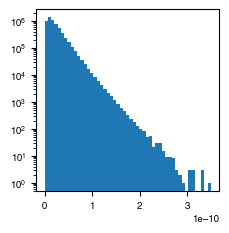

In [7]:
mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
ax1.hist(np.sort(np.abs(all_slices).reshape(-1)), bins=51)
ax1.set_yscale('log')

### Distribution of maximum XEB deviation that can result from a slice

In [8]:
m = 1522
n = 56
sample_amplitudes = np.sum(all_slices, axis=1)
sample_directions = sample_amplitudes / np.abs(sample_amplitudes)
rotated_slice_amplitudes = (all_slices.T * np.conj(sample_directions)).T
r = np.abs(rotated_slice_amplitudes)
theta = np.angle(rotated_slice_amplitudes)
R = np.max(np.abs(all_slices))
delta_probs = 2 * np.abs(np.tile(sample_amplitudes.reshape(-1, 1), all_slices.shape[1])) * (np.real(rotated_slice_amplitudes) + R)
delta_XEBs = 2**n * delta_probs / m

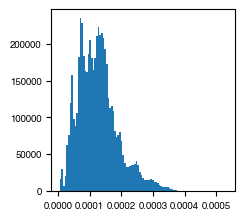

In [9]:
mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
ax1.hist(delta_XEBs.reshape(-1), bins=101);

### Scaling with $n_{\rm slices}$ or $F$

In [10]:
def solve_increasing(f, target, low, high):
    while low <= high:
        mid = (high + low) / 2
        if mid == high or mid == low:
            return mid
        ans = f(mid)
        error = ans - target
        if np.abs(error) / target < 0.01:
            return mid
        if error > 0:
            high = mid
        else:
            low = mid

In [11]:
f_target = 0.05

n = 56
m = 1522

prs = []

these_slices = all_slices


while these_slices.shape[-1] >= 128:

    sample_amplitudes = np.sum(these_slices, axis=1)
    sample_directions = sample_amplitudes / np.abs(sample_amplitudes)
    rotated_slice_amplitudes = (these_slices.T * np.conj(sample_directions)).T
    r = np.abs(rotated_slice_amplitudes)
    theta = np.angle(rotated_slice_amplitudes)
    R = np.max(np.abs(these_slices))
    delta_probs = 2 * np.abs(np.tile(sample_amplitudes.reshape(-1, 1), these_slices.shape[1])) * (np.real(rotated_slice_amplitudes) + R)
    delta_XEBs = 2**n * delta_probs / m

    def f_function(c):
        verification_probs = 1 - np.exp(-c*delta_XEBs)
        total_verification_budget = np.sum(verification_probs) * m / these_slices.shape[0]
        f = total_verification_budget / (these_slices.shape[1] * m)
        return f

    c = solve_increasing(f_function, f_target, 1, 2000)

    pr = np.exp(-c*0.02)
    prs.append(pr)

    these_slices = these_slices.reshape(these_slices.shape[0], -1, 2)
    these_slices = np.sum(these_slices, axis=2)

prs = np.array(prs)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


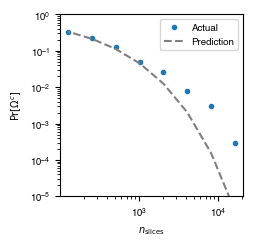

In [12]:
mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
ax1.plot(2**np.arange(14, 6, -1), prs, '.', label='Actual')
ax1.plot(2**np.arange(14, 6, -1), prs[-1]**np.sqrt(2**np.array([7,6,5,4,3,2,1,0])), '--', color='gray', label='Prediction')
ax1.set_ylim(10**-5, 1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$n_{\rm slices}$')
ax1.set_ylabel(r'$\Pr[\Omega^c]$')
plt.legend()
# plt.savefig('abort_probability_scaling_frontier.pdf')